# Entrenamiento inicial de nuestro modelo
En este notebook estará un modelo muy muy sencillo para empezar a practicar y detectar drift muy simple, se usará un modelo de clasificación de 2 variables, el modelo o proceso que define el evento "real" es:

$$
y = \begin{cases}
        1 & \text{if } x_2 > sx_1 \\
        0 & \text{otherwise}
    \end{cases}
$$

donde la variable $s$ representa la pendiente, donde por default diremos que es $-1$, por tanto creemos nuestros datos.

In [1]:
# Imports
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from scipy.stats import multivariate_normal

In [2]:
# Modelo/proceso verdero (ground true)
def true_model(X,slope=-1):
    z = slope*X[:,0]
    idx = np.argwhere(X[:,1]>z)
    y = np.zeros(X.shape[0])
    y[idx] = 1
    return y

true_slope = -1

Tomemos la distribución de referencia como una mezcla de dos distribuciones normales, solo para fines educativos.
$$
    P_{ref}(\mathbf{X}) = \phi_1\mathcal{N}\left(\left[-1,-1\right]^T, \sigma^2\mathbf{I} \right) + \phi\mathcal{N}\left(\left[-1,-1\right]^T, \sigma^2\mathbf{I} \right)
$$

con una desviación estándar de $\sigma=0.8$ y los pesos de $\phi_1 = \phi_2 = 0.5$. Los datos de referencia $\mathbf{X}^{ref}$ y los datos de entrenamiento $\mathbf{X}^{train}$ serán generados a partir de esta distribución de referencia. Y los labels $y^{ref}$, $y^{train}$ pueden igualmente ser obtenidos al evaluar el ```true_model()``` sobre los respectivos datos.

In [3]:
# Distribución de referencia
sigma = 0.8
phi1 = 0.5
phi2 = 0.5
ref_norm_0 = multivariate_normal([-1,-1], np.eye(2)*sigma**2)
ref_norm_1 = multivariate_normal([ 1, 1], np.eye(2)*sigma**2)

# Reference data
N_ref = 240
X_0 = ref_norm_0.rvs(size=int(N_ref*phi1),random_state=1)
X_1 = ref_norm_1.rvs(size=int(N_ref*phi2),random_state=1)
X_ref = np.vstack([X_0, X_1])
y_ref = true_model(X_ref,true_slope)

# Training data
N_train = 240
X_0 = ref_norm_0.rvs(size=int(N_train*phi1),random_state=0)
X_1 = ref_norm_1.rvs(size=int(N_train*phi2),random_state=0)
X_train = np.vstack([X_0, X_1])
y_train = true_model(X_train,true_slope)

In [4]:
# Función para plotear para ahorrar tiempo:
plt.rcParams.update({'font.size': 16})

def plot(X,y, slope, clf=None):
    # Init plot
    fig, ax = plt.subplots(figsize=(4,4))
    #ax.axis('equal')
    ax.set_xlabel(r'$x_1$')
    ax.set_ylabel(r'$x_2$')
    ax.set_xlim([-3.5,3.5])
    ax.set_ylim([-6,3.3])
    
    # Plot data
    cmap = LinearSegmentedColormap.from_list('my_cmap', [(0.78,0.44,0.22), (0.22, 0.44, 0.78)], N=2)
    scat = ax.scatter(X[:,0], X[:,1],c=y,ec='k',s=70,cmap=cmap,alpha=0.7)
    
    # Plot true decision boundary
    xconcept = np.array(ax.get_xlim())
    ax.plot(xconcept,xconcept*slope,'k--',lw=2,alpha=0.8)
    
    if clf is not None:
        # Plot classifier decision boundary
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        xx = np.linspace(xlim[0], xlim[1], 100)
        yy = np.linspace(ylim[0], ylim[1], 100)
        XX, YY = np.meshgrid(xx, yy)
        Z = clf.predict(np.c_[XX.ravel(), YY.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(XX.shape)
        ax.contourf(xx, yy, Z, cmap=cmap, alpha=.3, levels=1)
        ax.contour(xx, yy, Z, colors='k', linestyles=':', linewidths=[2,0], levels=1,alpha=0.8)

    plt.show()
    
labels = ['No','Yes']

Para el modelo, elegimos el conocido clasificador de árboles de decisión.

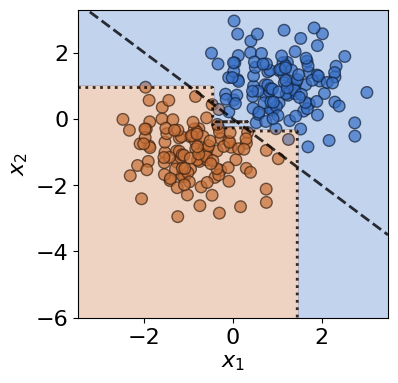

Mean training accuracy 98.75%


In [7]:
# Desision tree
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=20)
clf.fit(X_train, y_train)

# Plotear
plot(X_ref,y_ref,true_slope,clf=clf)

# Accuracy del modelo
print('Mean training accuracy %.2f%%' %(100*clf.score(X_ref,y_ref)))

In [8]:
# Alternatively, you can use pickle
import pickle
with open('model.pkl', 'wb') as file:
    pickle.dump(clf, file)

#### Veamos cómo se ve esto en la api